Дорогой студент!

В домашнем задании Lite вам предлагается поработать подробнее с параметрами словаря и формированием гиперпараметров нейронной сети. Создайте 9 нейросетей с различными гиперпараметрами (см. пунтк 2 и 3)

 Для этого необходимо:

  1. Воссоздать ноутбук, аналогичный ноутбуку практической части №1, загрузив при этом необходимую нам базу (код уже доступен в ноутбуке).

  2. Задать в ноутбуке следующие параметры для размера словаря, ширины окна и шага:

    - Размер словаря - от 10000 до 20000 (выбрать меньшее значение диапазона, если будет перегрузка ОЗУ и перезапуск подключения к Colaboratory)
    - Ширина окна - от 1000 до 2000
    - Шаг - от 100 до 500 (на обучение лучше влияет наименьший шаг, но это может перегрузить ОЗУ).

  3. Создать архитектуру сети и задать гиперпараметры. Можно воспользоваться шаблоном:
  
   - Добавьте модель прямого распространения **Sequential()**
   - Добавьте один или несколько полносвязных (**Dense**) слоёв
   - Добавьте слои **Dropout()** и **BatchNormalization()**
   - Добавьте выходной полносвязный слой с количеством нейронов, соответствующим количеству классов (число писателей)
  
   Напомним, что точность сети можно проверить по значению показателя 'val_accuracy' на конце каждой эпохи.
   

In [1]:
# Работа с массивами данных
import numpy as np

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Загрузка датасетов из облака google
import gdown

# Функции операционной системы
import os

# Работа со временем
import time

# Регулярные выражения
import re

# Запись в файлы и чтение из файлов структур данных Python
import pickle

# Отрисовка графиков
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [9]:
# Загрузка датасета из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l7/writers.zip', None, quiet=True)

'writers.zip'

In [10]:

# Распаковка архива в папку writers
!unzip -qo writers.zip -d writers/

# Просмотр содержимого папки
!ls writers

������� ������� ��������: 1251
������� ������� ��������: 1251


"ls" �� �������� ���������� ��� �������
��������, ����������� ���������� ��� �������� ������.


In [11]:
# Настройка констант для загрузки данных
FILE_DIR  = 'writers'                     # Папка с текстовыми файлами
SIG_TRAIN = 'обучающая'                   # Признак обучающей выборки в имени файла
SIG_TEST  = 'тестовая'                    # Признак тестовой выборки в имени файла

In [12]:
# Загрузка датасета. Добавляются имена классов и соответствующие тексты.
# Все тексты преобразуются в строку и объединяются для каждого класса и выборки
CLASS_LIST = []
text_train = []
text_test = []

for file_name in os.listdir(FILE_DIR):
    # Выделение имени класса и типа выборки из имени файла
    m = re.match('\((.+)\) (\S+)_', file_name)
    # Если выделение получилось, то файл обрабатывается
    if m:
        class_name = m[1]
        subset_name = m[2].lower()
        # Проверка типа выборки в имени файла
        is_train = SIG_TRAIN in subset_name
        is_test = SIG_TEST in subset_name

        # Если тип выборки обучающая либо тестовая - файл обрабатывается
        if is_train or is_test:
            # Добавление нового класса, если его еще нет в списке
            if class_name not in CLASS_LIST:
                print(f'Добавление класса "{class_name}"')
                CLASS_LIST.append(class_name)
                # Инициализация соответствующих классу строк текста
                text_train.append('')
                text_test.append('')

            # Поиск индекса класса для добавления содержимого файла в выборку
            cls = CLASS_LIST.index(class_name)
            print(f'Добавление файла "{file_name}" в класс "{CLASS_LIST[cls]}", {subset_name} выборка.')
            with open(f'{FILE_DIR}/{file_name}', 'r') as f:
                # Загрузка содержимого файла в строку
                text = f.read()
            # Определение выборки, куда будет добавлено содержимое
            subset = text_train if is_train else text_test
            # Добавление текста к соответствующей выборке класса. Концы строк заменяются на пробел
            subset[cls] += ' ' + text.replace('\n', ' ')

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

Добавление класса "Булгаков"
Добавление файла "(Булгаков) Обучающая_5 вместе.txt" в класс "Булгаков", обучающая выборка.
Добавление файла "(Булгаков) Тестовая_2 вместе.txt" в класс "Булгаков", тестовая выборка.
Добавление класса "Клиффорд_Саймак"
Добавление файла "(Клиффорд_Саймак) Обучающая_5 вместе.txt" в класс "Клиффорд_Саймак", обучающая выборка.
Добавление файла "(Клиффорд_Саймак) Тестовая_2 вместе.txt" в класс "Клиффорд_Саймак", тестовая выборка.
Добавление класса "Макс Фрай"
Добавление файла "(Макс Фрай) Обучающая_5 вместе.txt" в класс "Макс Фрай", обучающая выборка.
Добавление файла "(Макс Фрай) Тестовая_2 вместе.txt" в класс "Макс Фрай", тестовая выборка.
Добавление класса "О. Генри"
Добавление файла "(О. Генри) Обучающая_50 вместе.txt" в класс "О. Генри", обучающая выборка.
Добавление файла "(О. Генри) Тестовая_20 вместе.txt" в класс "О. Генри", тестовая выборка.
Добавление класса "Рэй Брэдберри"
Добавление файла "(Рэй Брэдберри) Обучающая_22 вместе.txt" в класс "Рэй Брэдберр

In [13]:
# Прочитанные классы текстов
print(CLASS_LIST)

# Количество текстов в обучающей выборке
print(len(text_train))

# Количество символов в одном из текстов обучающей выборки
print(len(text_train[3]))

['Булгаков', 'Клиффорд_Саймак', 'Макс Фрай', 'О. Генри', 'Рэй Брэдберри', 'Стругацкие']
6
1049518


In [14]:
# Проверка загрузки: вывод начальных отрывков из каждого класса
for cls in range(CLASS_COUNT):
    print(f'Класс: {CLASS_LIST[cls]}')
    print(f'  train: {text_train[cls][:200]}')
    print(f'  test : {text_test[cls][:200]}')
    print()

Класс: Булгаков
  train:  ﻿Белая гвардия   Посвящается[1]  Любови Евгеньевне Белозерской[2]  Пошел мелкий снег и вдруг повалил хло-  пьями. Ветер завыл; сделалась метель.  В одно мгновение темное небо смешалось с  снежным мор
  test :  ﻿Дон Кихот ДЕЙСТВУЮЩИЕ ЛИЦА Алонсо Кихано, он же Дон Кихот Ламанчский.  Антония – его племянница.  Ключница Дон Кихота.  Санчо Панса – оруженосец Дон Кихота.  Перо Перес – деревенский священник, лице

Класс: Клиффорд_Саймак
  train:  ﻿Всё живое...     Когда я выехал из нашего городишка и повернул на шоссе, позади оказался грузовик. Этакая тяжелая громадина с прицепом, и неслась она во весь дух. Шоссе здесь срезает угол городка, и
  test :  ﻿Зачарованное паломничество    1  Гоблин со стропил следил за прячущимся монахом, который шпионил за ученым. Гоблин ненавидел монаха и имел для этого все основания. Монах никого не ненавидел и не люб

Класс: Макс Фрай
  train:  ﻿Власть несбывшегося   – С тех пор как меня угораздило побывать в этой грешной Черхавле, мне

In [15]:
# Задание параметров преобразования
VOCAB_SIZE = 20000                        # Объем словаря для токенизатора
WIN_SIZE   = 1000                         # Длина отрезка текста (окна) в словах
WIN_HOP    = 100                          # Шаг окна разбиения текста на векторы

In [16]:
# Контекстный менеджер для измерения времени операций
# Операция обертывается менеджером с помощью оператора with
class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        print('Время обработки: {:.2f} с'.format(time.time() - self.t))

In [17]:
# Токенизация и построение частотного словаря по обучающим текстам
with timex():
    # Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                          lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

    # Использованы параметры:
    # num_words   - объем словаря
    # filters     - убираемые из текста ненужные символы
    # lower       - приведение слов к нижнему регистру
    # split       - разделитель слов
    # char_level  - указание разделять по словам, а не по единичным символам
    # oov_token   - токен для слов, которые не вошли в словарь

    # Построение частотного словаря по обучающим текстам
    tokenizer.fit_on_texts(text_train)

    # Построение словаря в виде пар слово - индекс
    items = list(tokenizer.word_index.items())

Время обработки: 2.04 с


In [13]:
# Вывод нескольких наиболее часто встречающихся слов
print(items[:120])

# Размер словаря может быть больше, чем num_words, но при преобразовании в последовательности
# и векторы bag of words будут учтены только первые num_words слов
print("Размер словаря", len(items))

[('неизвестное_слово', 1), ('и', 2), ('в', 3), ('не', 4), ('я', 5), ('что', 6), ('на', 7), ('с', 8), ('он', 9), ('а', 10), ('как', 11), ('то', 12), ('это', 13), ('но', 14), ('все', 15), ('у', 16), ('по', 17), ('его', 18), ('к', 19), ('так', 20), ('мне', 21), ('из', 22), ('за', 23), ('меня', 24), ('ты', 25), ('же', 26), ('бы', 27), ('сказал', 28), ('вы', 29), ('было', 30), ('от', 31), ('они', 32), ('мы', 33), ('только', 34), ('да', 35), ('еще', 36), ('она', 37), ('о', 38), ('вот', 39), ('когда', 40), ('если', 41), ('уже', 42), ('был', 43), ('нет', 44), ('ни', 45), ('их', 46), ('ну', 47), ('чтобы', 48), ('до', 49), ('для', 50), ('ему', 51), ('ничего', 52), ('может', 53), ('или', 54), ('даже', 55), ('там', 56), ('очень', 57), ('кто', 58), ('ее', 59), ('тут', 60), ('потом', 61), ('просто', 62), ('чем', 63), ('него', 64), ('быть', 65), ('теперь', 66), ('под', 67), ('где', 68), ('нас', 69), ('есть', 70), ('тебя', 71), ('ли', 72), ('время', 73), ('тебе', 74), ('вас', 75), ('со', 76), ('нибудь

In [18]:
# Преобразование обучающих и проверочных текстов в последовательность индексов согласно частотному словарю
with timex():
    seq_train = tokenizer.texts_to_sequences(text_train)
    seq_test = tokenizer.texts_to_sequences(text_test)

    print("Фрагмент обучающего текста:")
    print("В виде оригинального текста:              ", text_train[1][:101])
    print("Он же в виде последовательности индексов: ", seq_train[1][:20])

Фрагмент обучающего текста:
В виде оригинального текста:                ﻿Всё живое...     Когда я выехал из нашего городишка и повернул на шоссе, позади оказался грузовик. 
Он же в виде последовательности индексов:  [142, 2904, 40, 5, 11721, 22, 513, 1, 2, 1817, 7, 941, 956, 593, 2195, 12030, 4602, 1, 8, 1]
Время обработки: 1.94 с


In [19]:
# Функция вывода статистики по текстам
def print_text_stats(title, texts, sequences, class_labels=CLASS_LIST):
    # Суммарное количество символов и слов в тексте
    chars = 0
    words = 0

    print(f'Статистика по {title} текстам:')

    # Вывод итогов по всем классам данного набора текстов и их последовательностей индексов
    for cls in range(len(class_labels)):
        print('{:<15} {:9} символов,{:8} слов'.format(class_labels[cls],
                                                      len(texts[cls]),
                                                      len(sequences[cls])))
        chars += len(texts[cls])
        words += len(sequences[cls])

    print('----')
    print('{:<15} {:9} символов,{:8} слов\n'.format('В сумме', chars, words))

# Вывод итогов по текстам
print_text_stats('обучающим', text_train, seq_train)
print_text_stats('тестовым', text_test, seq_test)

Статистика по обучающим текстам:
Булгаков          1765649 символов,  261465 слов
Клиффорд_Саймак   1609508 символов,  251502 слов
Макс Фрай         3700011 символов,  568533 слов
О. Генри          1049518 символов,  160607 слов
Рэй Брэдберри     1386455 символов,  214454 слов
Стругацкие        2042470 символов,  313012 слов
----
В сумме          11553611 символов, 1769573 слов

Статистика по тестовым текстам:
Булгаков           875043 символов,  132730 слов
Клиффорд_Саймак    318812 символов,   50360 слов
Макс Фрай         1278192 символов,  196731 слов
О. Генри           349663 символов,   53238 слов
Рэй Брэдберри      868674 символов,  132524 слов
Стругацкие         704847 символов,  108621 слов
----
В сумме           4395231 символов,  674204 слов



In [20]:
# Функция разбиения последовательности на отрезки скользящим окном
# На входе - последовательность индексов, размер окна, шаг окна
def split_sequence(sequence, win_size, hop):
    # Последовательность разбивается на части до последнего полного окна
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]


# Функция формирования выборок из последовательностей индексов
# формирует выборку отрезков и соответствующих им меток классов в виде one hot encoding
def vectorize_sequence(seq_list, win_size, hop):
    # В списке последовательности следуют в порядке их классов
    # Всего последовательностей в списке ровно столько, сколько классов
    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):
        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)
        # Добавление отрезков в выборку
        x += vectors
        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)

In [21]:
# Формирование обучающей и тестовой выборок
with timex():
    # Формирование обучающей выборки
    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
    # Формирование тестовой выборки
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

    # Проверка формы сформированных данных
    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)

(17640, 1000) (17640, 6)
(6686, 1000) (6686, 6)
Время обработки: 1.13 с


In [18]:
# Вывод отрезка индексов тренировочной выборки
print(x_train[0])

[ 2927  5383     1  1496     1     1 15510  1511   353  8288  1255     2
   121 14307     1     1   675 11508 10220 17013     3   275  1066  4725
   637     1     8     1  6482    15  2782    47     1  1181     1  1636
     1  1540     1  7010     2     1    94  3211   930    17     1     3
  5197 18830     8  3906   532  5765    43   488     2  8682   488    17
     1     1  2692    31   505    26  4242   548  2381    43     9     1
  2834  3437    10     1  4591     2   597  1966     3  1217   800   392
  1829  4592     1     1     1     2  2298 18831  4243  2989    14   839
     2     3 18832     2     3 14308   924 14309    11  8683     2  3438
     1  3745     4  3907    11     3     1     1 10855   935  6255     1
    38     1  1359   321  9134  4591     2 17014  1192 10856  4465    68
    26    25  3155   103   488   127    97    11  2232  1050  3592     1
     8 15511     1     1     1  3824     2     3   570  1200    40  1310
  1067  4343  3593   762  3746   127     1     1  3

In [22]:
# Формирование выборок текстов в виде разреженных матриц (bag of words)
with timex():
    # На входе .sequences_to_matrix() ожидает список, .tolist() выполняет преобразование типа
    x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())
    x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())

    # Вывод формы обучающей выборки в виде разреженной матрицы Bag of Words
    print(x_train_01.shape)
    # Вывод фрагмента отрезка обучающего текста в виде Bag of Words
    print(x_train_01[0][0:100])

(17640, 20000)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0.
 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1.
 0. 1. 1. 0.]
Время обработки: 7.06 с


In [24]:
# Функция компиляции и обучения модели нейронной сети
def compile_train_model(model,
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='adam',
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5)):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


# Функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model,
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels=CLASS_LIST,
                             title='',
                             optimizer='adam',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(10, 10)):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test,
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

##Пример 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │     4,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,206 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,002,206 (15.27 MB)

 Trainable params: 4,001,806 (15.27 MB)

 Non-trainable params: 400 (1.56 KB)

Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9347 - loss: 0.1964 - val_accuracy: 0.8865 - val_loss: 0.3838
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 4.0415e-04 - val_accuracy: 0.8931 - val_loss: 0.3297
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 1.0000 - loss: 1.9589e-04 - val_accuracy: 0.8978 - val_loss: 0.3134
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.0000 - loss: 1.2858e-04 - val_accuracy: 0.8955 - val_loss: 0.3150
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 1.0000 - loss: 9.0855e-05 - val_accuracy: 0.8966 - val_loss: 0.3089
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 1.0000 - loss: 6.8365e-05 - val_accuracy: 0.8992 - val_loss: 0.3037
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 1.0000 - loss: 5.6401e-05 - val_accuracy: 0.8999 - val_loss: 0.3008
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 1.0000 -

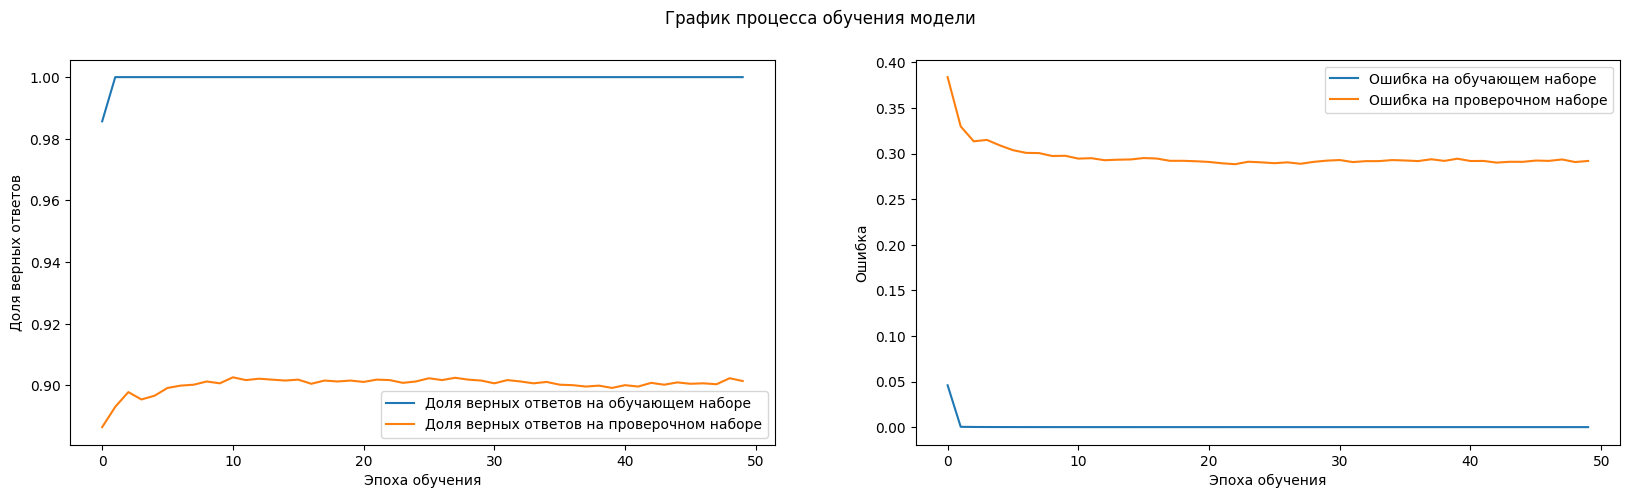

209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


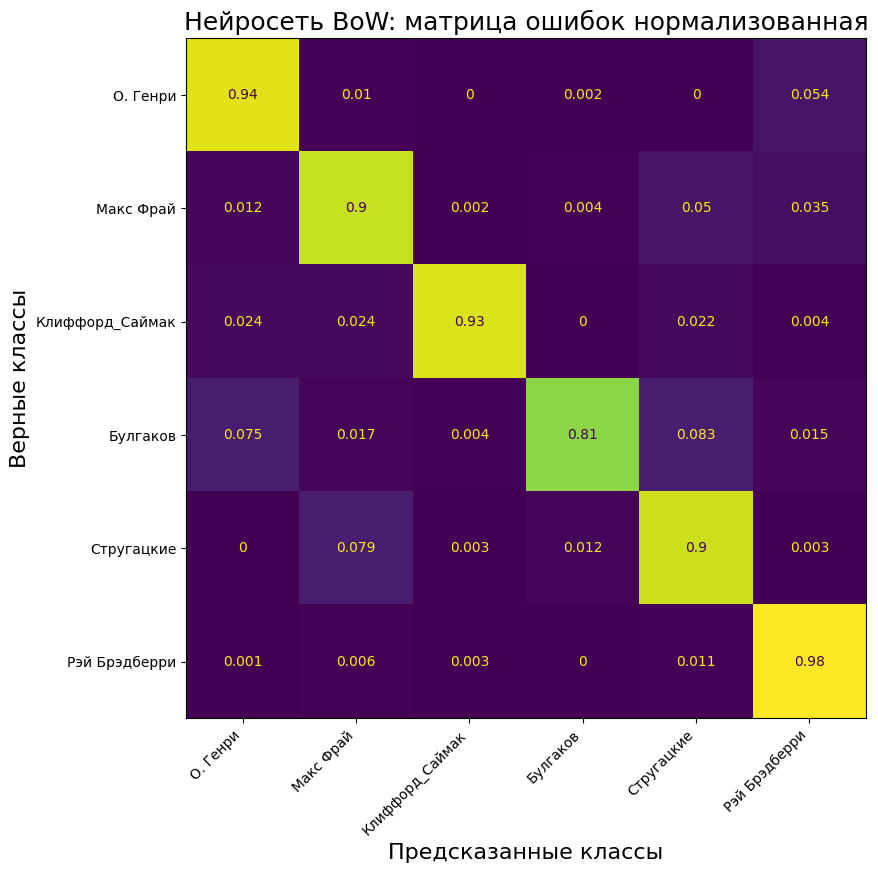

----------------------------------------------------------------------------------------------------
Нейросеть: BoW
Класс: О. Генри              94% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Макс Фрай             90% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Клиффорд_Саймак       92% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)
Класс: Булгаков              81% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Стругацкие            90% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: Рэй Брэдберри         98% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)

Средняя точность распознавания:  91%


In [19]:
# Создание последовательной модели нейросети
model_text_bow_softmax = Sequential()
# Первый полносвязный слой
model_text_bow_softmax.add(Dense(200, input_dim=VOCAB_SIZE, activation="relu"))
# Слой регуляризации Dropout
model_text_bow_softmax.add(Dropout(0.25))
# Слой пакетной нормализации
model_text_bow_softmax.add(BatchNormalization())
# Выходной полносвязный слой
model_text_bow_softmax.add(Dense(CLASS_COUNT, activation='softmax'))

# Входные данные подаются в виде векторов bag of words
compile_train_eval_model(model_text_bow_softmax,
                         x_train_01, y_train,
                         x_test_01, y_test,
                         class_labels=CLASS_LIST,
                         title='BoW')

##Архитектура 1

Время обработки: 14.74 с


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 512)            │     5,120,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,255,430 (20.05 MB)

 Trainable params: 5,254,406 (20.04 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.8954 - loss: 0.3129 - val_accuracy: 0.9076 - val_loss: 0.3371
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 1.0000 - loss: 6.8594e-04 - val_accuracy: 0.9080 - val_loss: 0.2879
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.8110e-04 - val_accuracy: 0.9044 - val_loss: 0.2892
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.3352e-04 - val_accuracy: 0.9034 - val_loss: 0.2871
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.0721e-04 - val_accuracy: 0.9055 - val_loss: 0.2850
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 8.3924e-05 - val_accuracy: 0.9029 - val_loss: 0.2897
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 5.7671e-05 - val_accuracy: 0.9025 - val_loss: 0.2933
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 

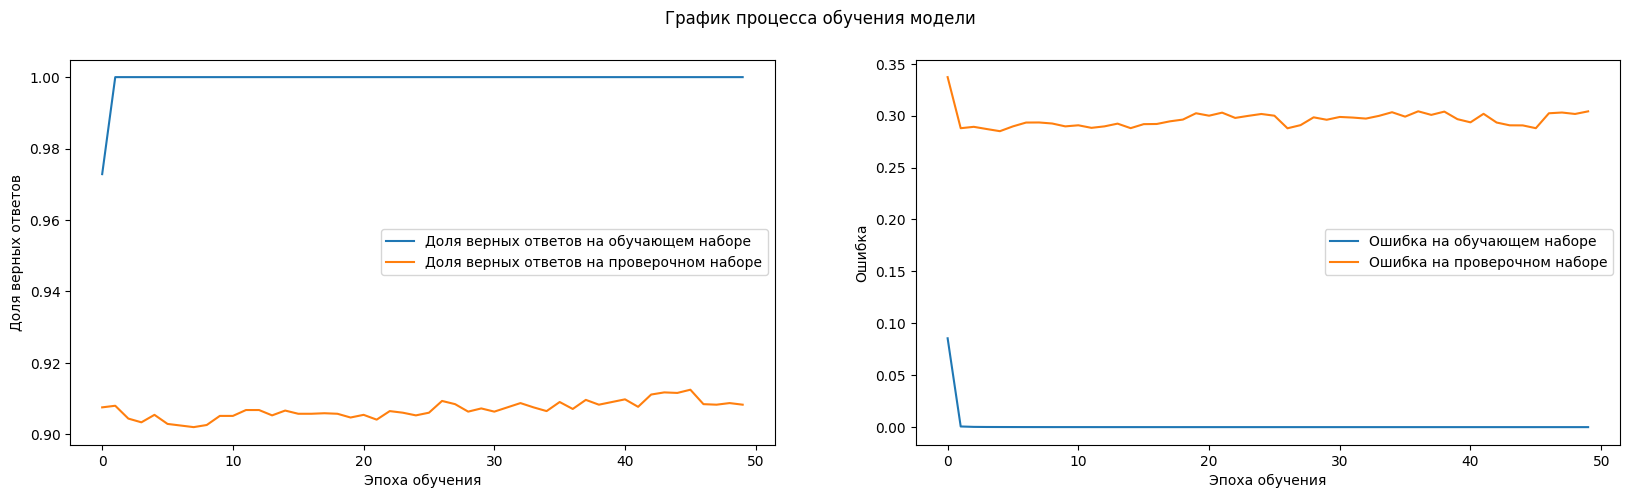

209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


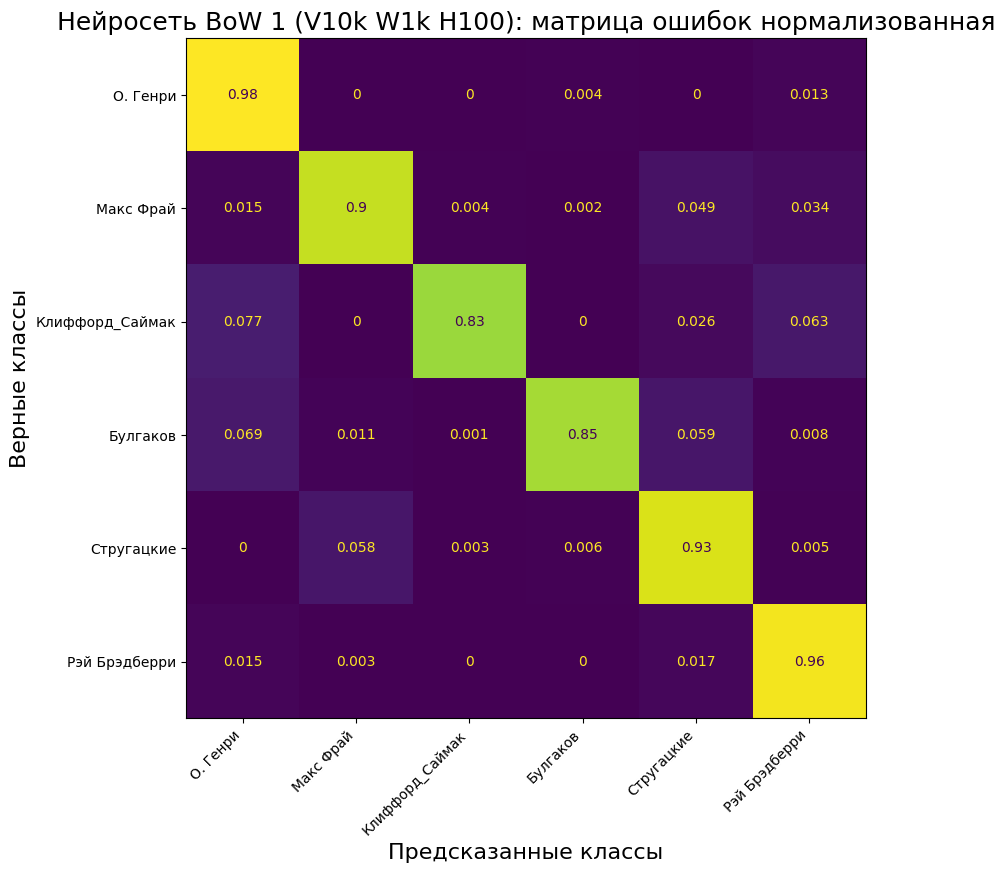

----------------------------------------------------------------------------------------------------
Нейросеть: BoW 1 (V10k W1k H100)
Класс: О. Генри              98% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Макс Фрай             90% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Клиффорд_Саймак       83% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)
Класс: Булгаков              85% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Стругацкие            93% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: Рэй Брэдберри         96% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)

Средняя точность распознавания:  91%


In [20]:

with timex():
    # Установка параметров
    VOCAB_SIZE = 10000
    WIN_SIZE = 1000
    WIN_HOP = 100

    # Обработка данных
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                        lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
    tokenizer.fit_on_texts(text_train)
    seq_train = tokenizer.texts_to_sequences(text_train)
    seq_test = tokenizer.texts_to_sequences(text_test)

    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

    # Преобразование в BoW
    x_train_bow = tokenizer.sequences_to_matrix(x_train.tolist())
    x_test_bow = tokenizer.sequences_to_matrix(x_test.tolist())

# Создание модели
model_bow_1 = Sequential()
model_bow_1.add(Dense(512, input_dim=VOCAB_SIZE, activation='relu'))
model_bow_1.add(Dropout(0.4))
model_bow_1.add(BatchNormalization())
model_bow_1.add(Dense(256, activation='relu'))
model_bow_1.add(Dropout(0.3))
model_bow_1.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_bow_1,
                        x_train_bow, y_train,
                        x_test_bow, y_test,
                        title='BoW 1 (V10k W1k H100)')

##Архитектура 2

Время обработки: 7.63 с


d:\anaconda3\envs\Neural_Networks\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     7,680,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,816,454 (29.82 MB)

 Trainable params: 7,814,918 (29.81 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.8468 - loss: 0.4634 - val_accuracy: 0.7694 - val_loss: 0.6298
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.8622 - val_loss: 0.4163
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 1.0000 - loss: 8.7459e-04 - val_accuracy: 0.8914 - val_loss: 0.3397
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 1.0000 - loss: 4.6772e-04 - val_accuracy: 0.8991 - val_loss: 0.3076
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 1.0000 - loss: 3.8696e-04 - val_accuracy: 0.8977 - val_loss: 0.2990
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 1.0000 - loss: 3.0738e-04 - val_accuracy: 0.9032 - val_loss: 0.2889
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 1.0000 - loss: 2.5607e-04 - val_accuracy: 0.9036 - val_loss: 0.2814
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 1.0000 - loss: 2.3601e-04 - 

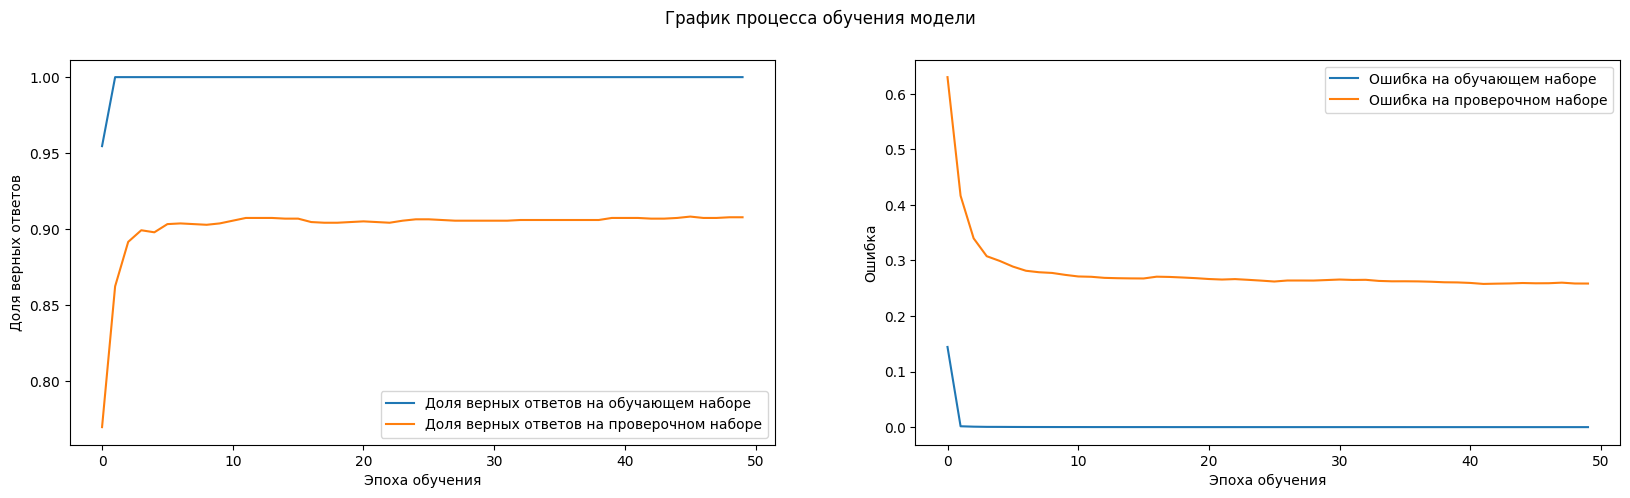

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


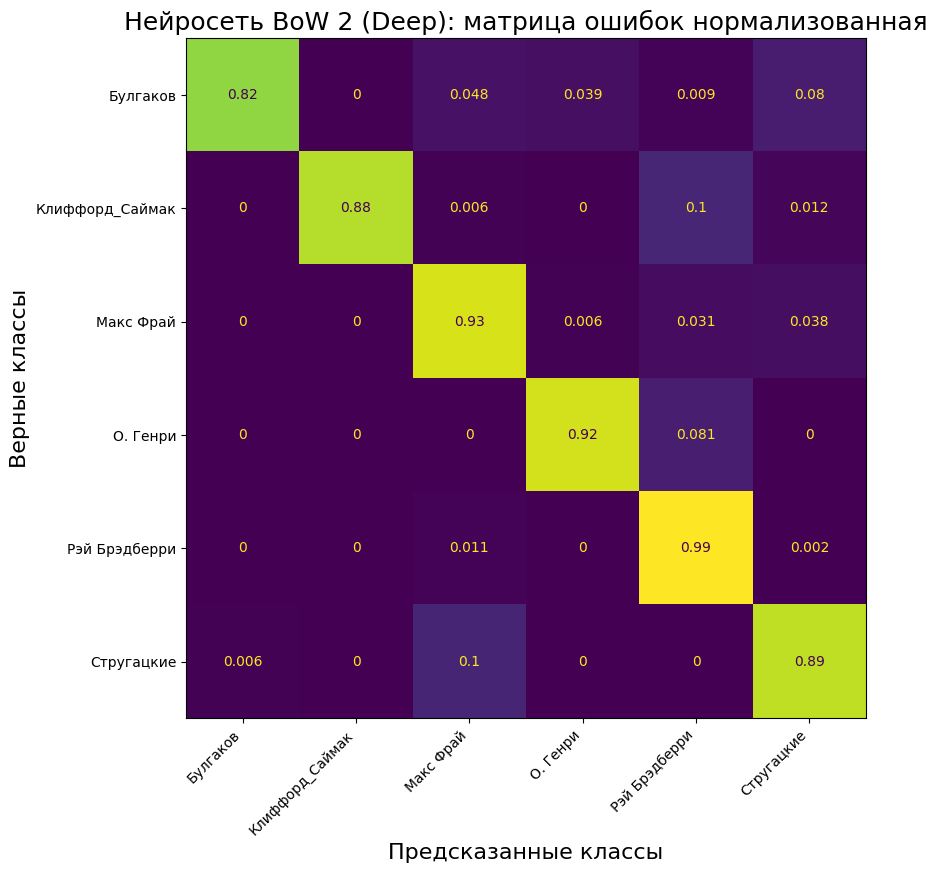

----------------------------------------------------------------------------------------------------
Нейросеть: BoW 2 (Deep)
Класс: Булгаков              82% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Клиффорд_Саймак       88% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)
Класс: Макс Фрай             92% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: О. Генри              92% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Рэй Брэдберри         99% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Стругацкие            89% сеть отнесла к классу Стругацкие           - ВЕРНО :-)

Средняя точность распознавания:  90%


In [25]:
with timex():
    # Установка параметров
    VOCAB_SIZE = 15000
    WIN_SIZE = 1500
    WIN_HOP = 300

    # Обработка данных
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                        lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
    tokenizer.fit_on_texts(text_train)
    seq_train = tokenizer.texts_to_sequences(text_train)
    seq_test = tokenizer.texts_to_sequences(text_test)

    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

    # Преобразование в BoW
    x_train_bow = tokenizer.sequences_to_matrix(x_train.tolist())
    x_test_bow = tokenizer.sequences_to_matrix(x_test.tolist())

# Автоматическое использование GPU
with tf.device('/GPU:0'):
    model_bow_2 = Sequential()
    model_bow_2.add(Dense(512, input_dim=VOCAB_SIZE, activation="relu"))
    model_bow_2.add(Dropout(0.3))
    model_bow_2.add(BatchNormalization())
    model_bow_2.add(Dense(256, activation="relu"))
    model_bow_2.add(Dropout(0.2))
    model_bow_2.add(BatchNormalization())
    model_bow_2.add(Dense(CLASS_COUNT, activation='softmax'))
    compile_train_eval_model(model_bow_2,
                             x_train_bow, y_train,
                             x_test_bow, y_test,
                             title='BoW 2 (Deep)')

##Архитектура 3

Время обработки: 9.84 с


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 1024)           │    20,481,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,491,270 (78.17 MB)

 Trainable params: 20,489,222 (78.16 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.8589 - loss: 0.4169 - val_accuracy: 0.8012 - val_loss: 0.5907
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 8.0493e-04 - val_accuracy: 0.8780 - val_loss: 0.3863
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 2.4111e-04 - val_accuracy: 0.9044 - val_loss: 0.3090
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.4687e-04 - val_accuracy: 0.9096 - val_loss: 0.2746
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.1055e-04 - val_accuracy: 0.9134 - val_loss: 0.2560
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 8.5630e-05 - val_accuracy: 0.9172 - val_loss: 0.2472
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 7.5489e-05 - val_accuracy: 0.9232 - val_loss: 0.2417
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 5.9717e-

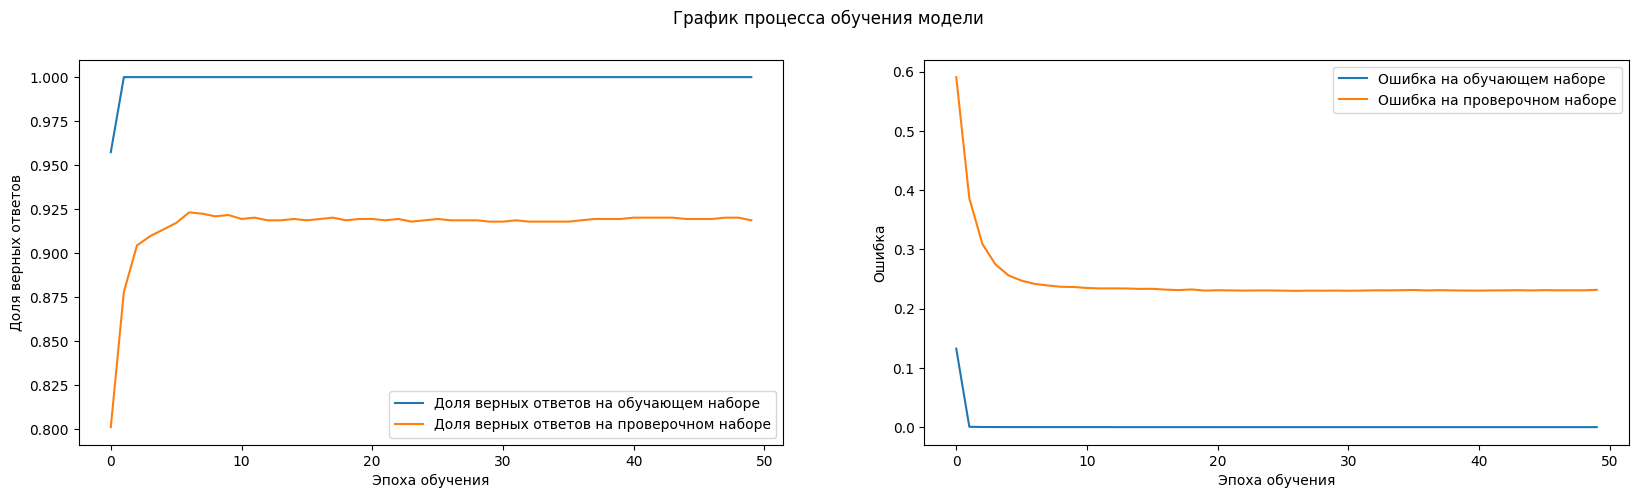

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


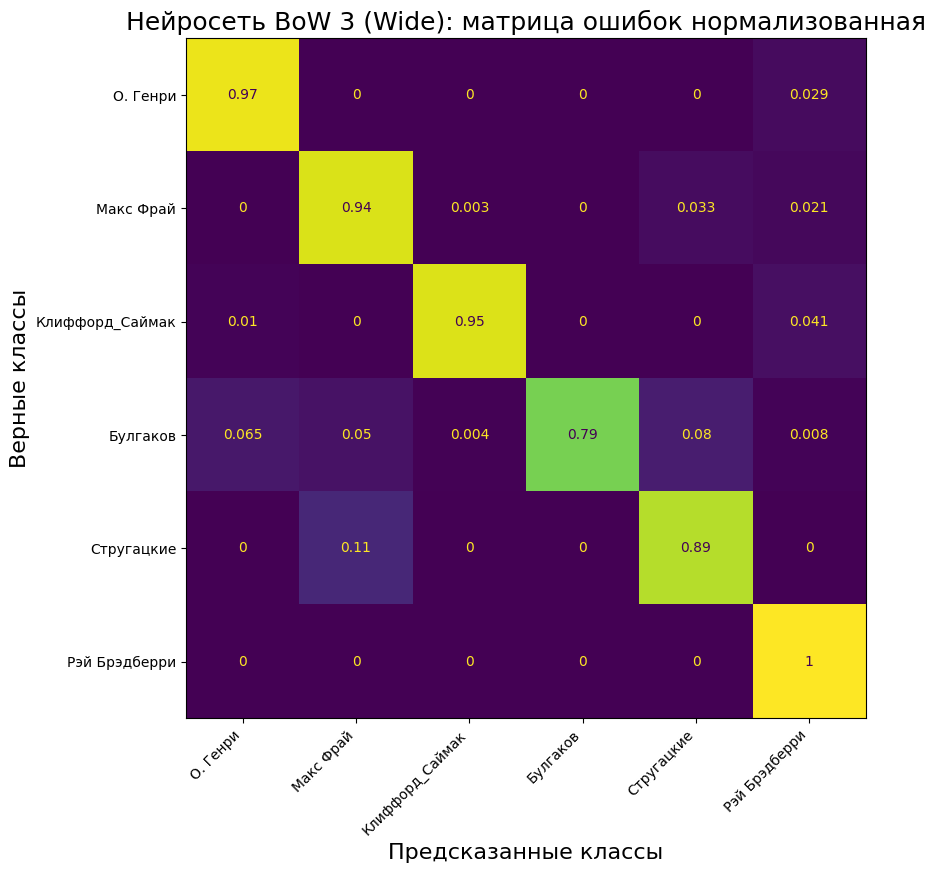

----------------------------------------------------------------------------------------------------
Нейросеть: BoW 3 (Wide)
Класс: О. Генри              97% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Макс Фрай             94% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Клиффорд_Саймак       95% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)
Класс: Булгаков              79% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Стругацкие            89% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: Рэй Брэдберри        100% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)

Средняя точность распознавания:  92%


In [23]:
with timex():
    # Установка параметров
    VOCAB_SIZE = 20000
    WIN_SIZE = 2000
    WIN_HOP = 500

    # Обработка данных
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                        lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
    tokenizer.fit_on_texts(text_train)
    seq_train = tokenizer.texts_to_sequences(text_train)
    seq_test = tokenizer.texts_to_sequences(text_test)

    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

    # Преобразование в BoW
    x_train_bow = tokenizer.sequences_to_matrix(x_train.tolist())
    x_test_bow = tokenizer.sequences_to_matrix(x_test.tolist())


model_bow_3 = Sequential()
model_bow_3.add(Dense(1024, input_dim=VOCAB_SIZE, activation="relu"))
model_bow_3.add(Dropout(0.5))
model_bow_3.add(BatchNormalization())
model_bow_3.add(Dense(CLASS_COUNT, activation='softmax'))
compile_train_eval_model(model_bow_3,
                         x_train_bow, y_train,
                         x_test_bow, y_test,
                         title='BoW 3 (Wide)')

##Архитектура 4

Время обработки: 7.25 с


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.5439 - loss: 1.7785 - val_accuracy: 0.1663 - val_loss: 1.9270
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9991 - loss: 0.0310 - val_accuracy: 0.3241 - val_loss: 1.6246
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 1.0000 - loss: 0.0081 - val_accuracy: 0.3220 - val_loss: 1.5849
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.3532 - val_loss: 1.5047
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.4038 - val_loss: 1.3827
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.5024 - val_loss: 1.2283
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.5881 - val_loss: 1.0998
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.6243 - 

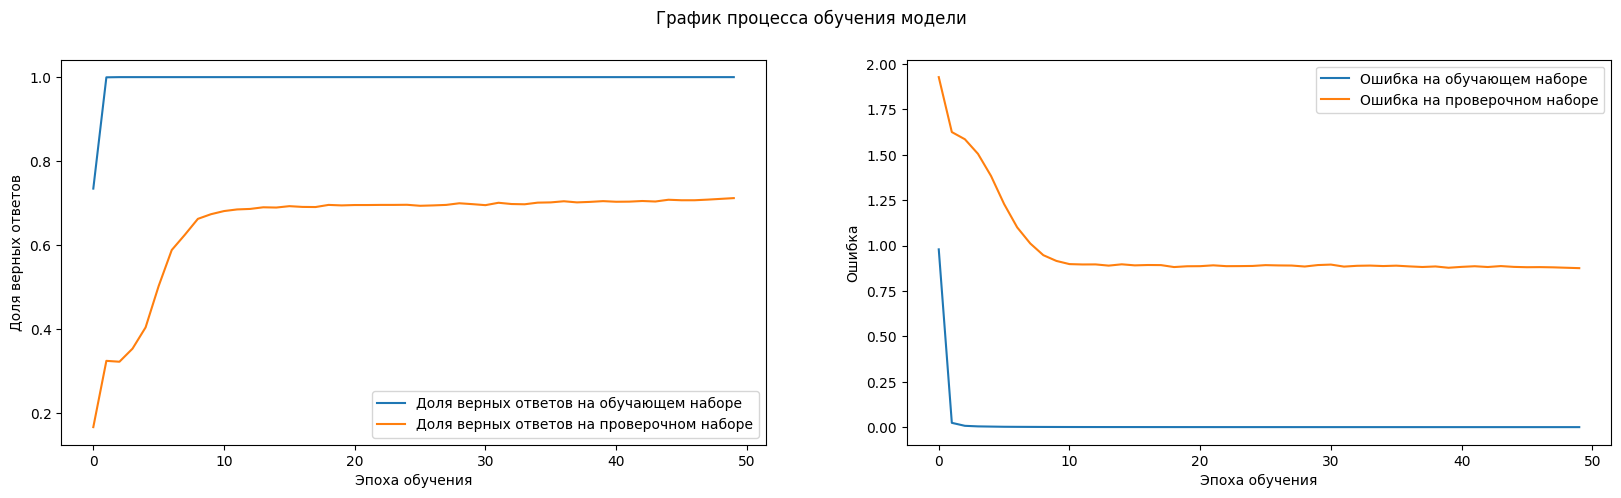

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


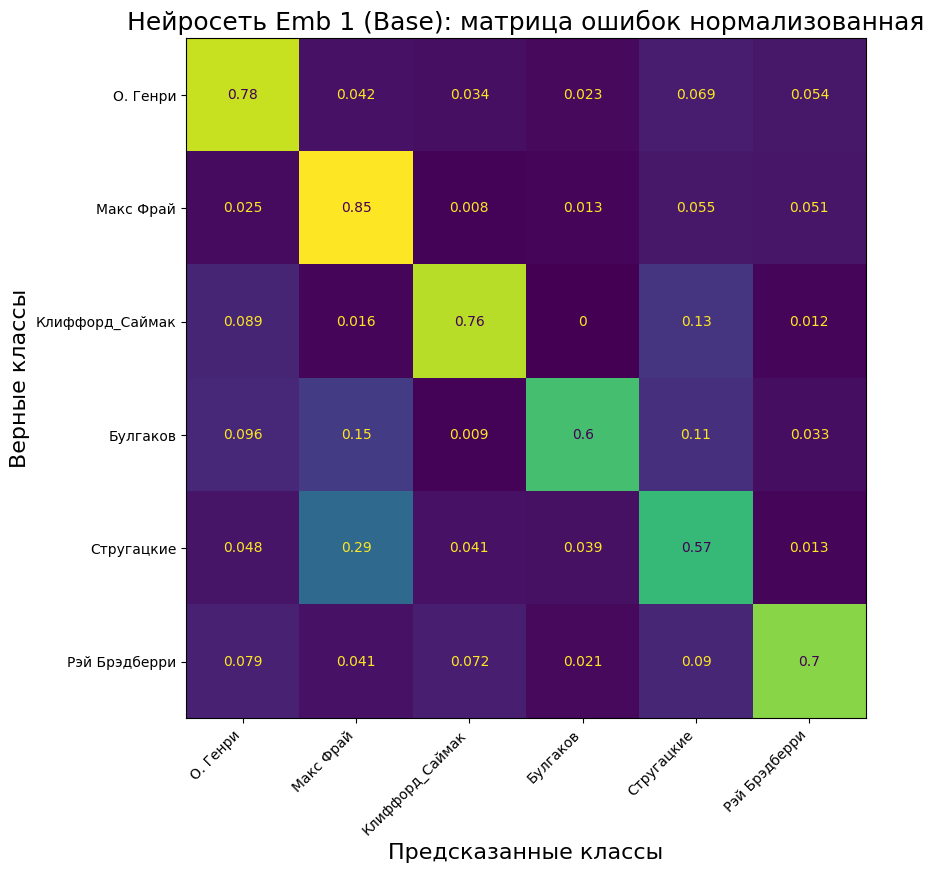

----------------------------------------------------------------------------------------------------
Нейросеть: Emb 1 (Base)
Класс: О. Генри              78% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Макс Фрай             85% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Клиффорд_Саймак       76% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)
Класс: Булгаков              60% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Стругацкие            57% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: Рэй Брэдберри         70% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)

Средняя точность распознавания:  71%


In [24]:
with timex():
    # Установка параметров
    VOCAB_SIZE = 12000
    WIN_SIZE = 1200
    WIN_HOP = 200

    # Обработка данных
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                        lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
    tokenizer.fit_on_texts(text_train)
    seq_train = tokenizer.texts_to_sequences(text_train)
    seq_test = tokenizer.texts_to_sequences(text_test)

    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)


model_emb_1 = Sequential()
model_emb_1.add(Embedding(VOCAB_SIZE, 200, input_length=WIN_SIZE))
model_emb_1.add(SpatialDropout1D(0.2))
model_emb_1.add(Flatten())
model_emb_1.add(BatchNormalization())
model_emb_1.add(Dense(200, activation="relu"))
model_emb_1.add(Dropout(0.2))
model_emb_1.add(BatchNormalization())
model_emb_1.add(Dense(CLASS_COUNT, activation='softmax'))
compile_train_eval_model(model_emb_1,
                         x_train, y_train,
                         x_test, y_test,
                         title='Emb 1 (Base)')

##Архитектура 5

Время обработки: 6.53 с


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 249ms/step - accuracy: 0.4318 - loss: 1.6295 - val_accuracy: 0.3773 - val_loss: 1.6178
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9924 - loss: 0.0738 - val_accuracy: 0.5259 - val_loss: 1.1814
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 0.5866 - val_loss: 1.0596
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.6047 - val_loss: 1.0248
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.6119 - val_loss: 1.0243
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.6203 - val_loss: 1.0177
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.6288 - val_loss: 1.0090
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 1.0000 - loss: 7.1013e-04 - val_accuracy: 0.6

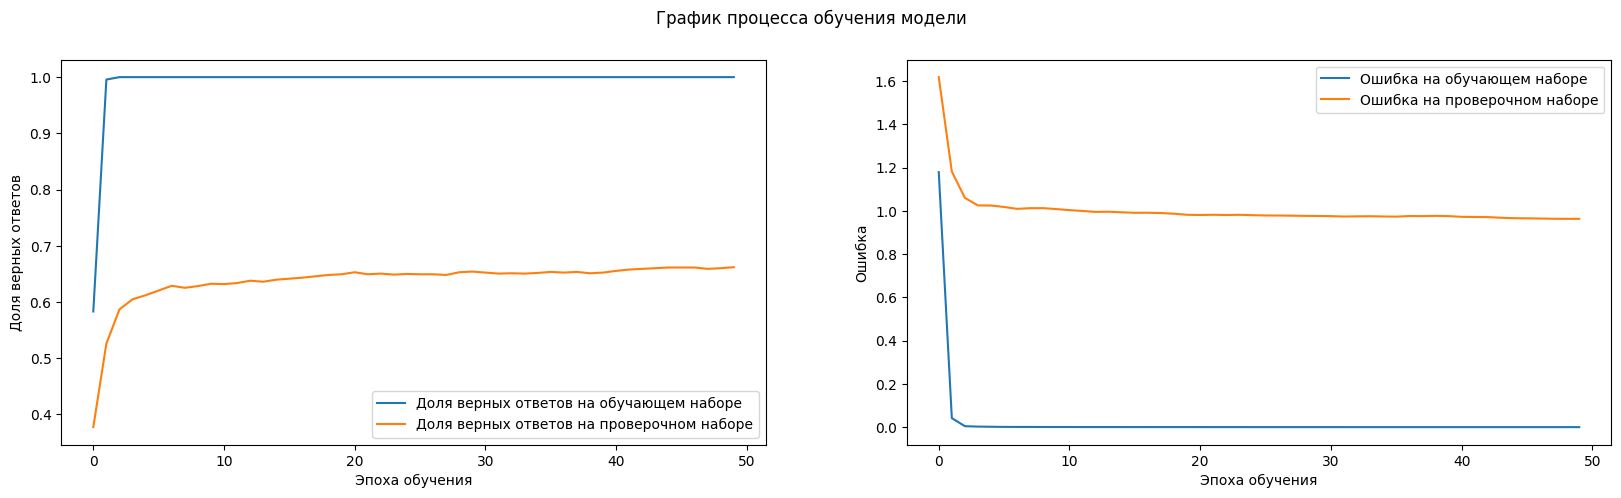

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


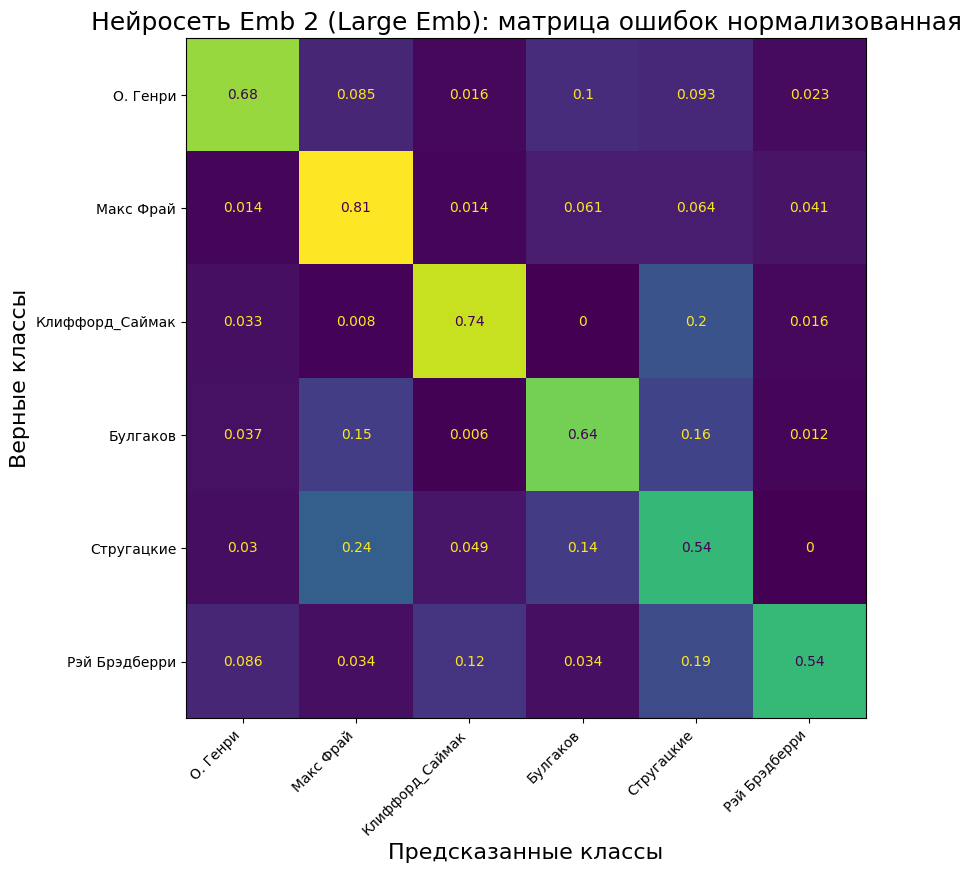

----------------------------------------------------------------------------------------------------
Нейросеть: Emb 2 (Large Emb)
Класс: О. Генри              68% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Макс Фрай             80% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Клиффорд_Саймак       74% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)
Класс: Булгаков              64% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Стругацкие            54% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: Рэй Брэдберри         54% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)

Средняя точность распознавания:  66%


In [25]:
with timex():
    # Установка параметров
    VOCAB_SIZE = 16000
    WIN_SIZE = 1800
    WIN_HOP = 400

    # Обработка данных
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                        lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
    tokenizer.fit_on_texts(text_train)
    seq_train = tokenizer.texts_to_sequences(text_train)
    seq_test = tokenizer.texts_to_sequences(text_test)

    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)


model_emb_2 = Sequential()
model_emb_2.add(Embedding(VOCAB_SIZE, 300, input_length=WIN_SIZE))
model_emb_2.add(SpatialDropout1D(0.3))
model_emb_2.add(Flatten())
model_emb_2.add(Dense(300, activation="relu"))
model_emb_2.add(Dropout(0.3))
model_emb_2.add(BatchNormalization())
model_emb_2.add(Dense(CLASS_COUNT, activation='softmax'))
compile_train_eval_model(model_emb_2,
                         x_train, y_train,
                         x_test, y_test,
                         title='Emb 2 (Large Emb)')

##Архитектура 6

Время обработки: 5.36 с


d:\anaconda3\envs\Neural_Networks\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.6691 - loss: 0.8821 - val_accuracy: 0.7700 - val_loss: 0.7469
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.9986 - loss: 0.0057 - val_accuracy: 0.8224 - val_loss: 0.5786
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 1.0000 - loss: 6.1598e-04 - val_accuracy: 0.8227 - val_loss: 0.5635
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 1.0000 - loss: 3.3902e-04 - val_accuracy: 0.8195 - val_loss: 0.5839
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 1.0000 - loss: 2.0151e-04 - val_accuracy: 0.8204 - val_loss: 0.5909
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 1.0000 - loss: 1.5499e-04 - val_accuracy: 0.8172 - val_loss: 0.5987
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 1.0000 - loss: 8.0280e-05 - val_accuracy: 0.8147 - val_loss: 0.6240
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 1.0000 - los

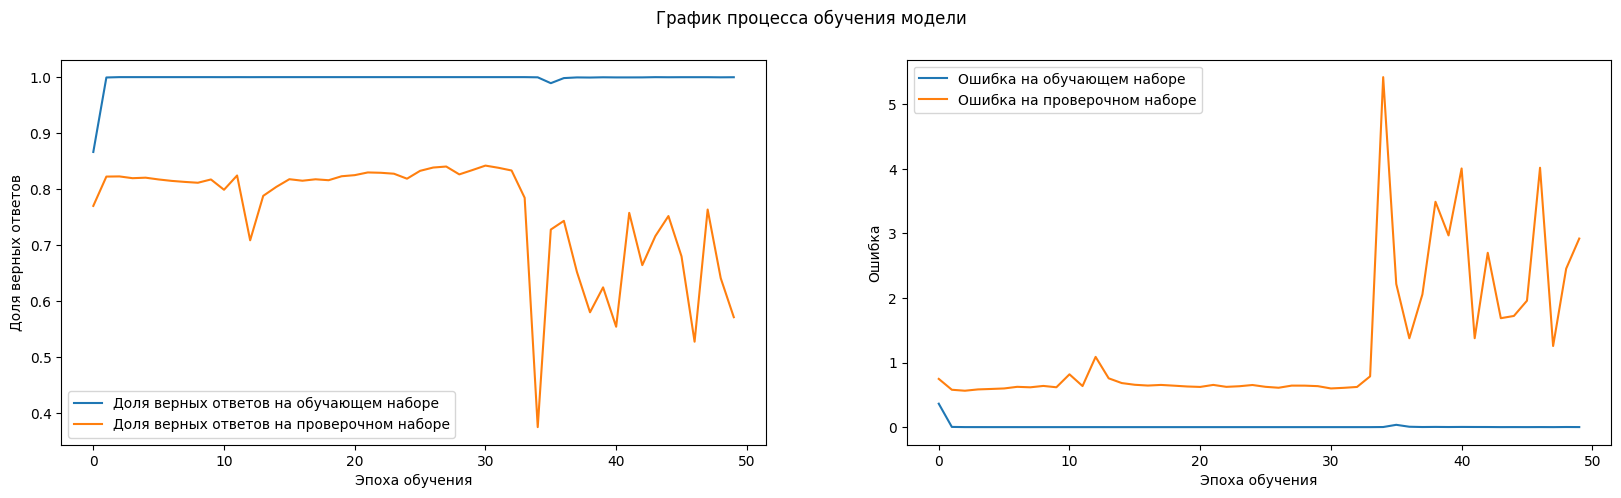

208/208 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step


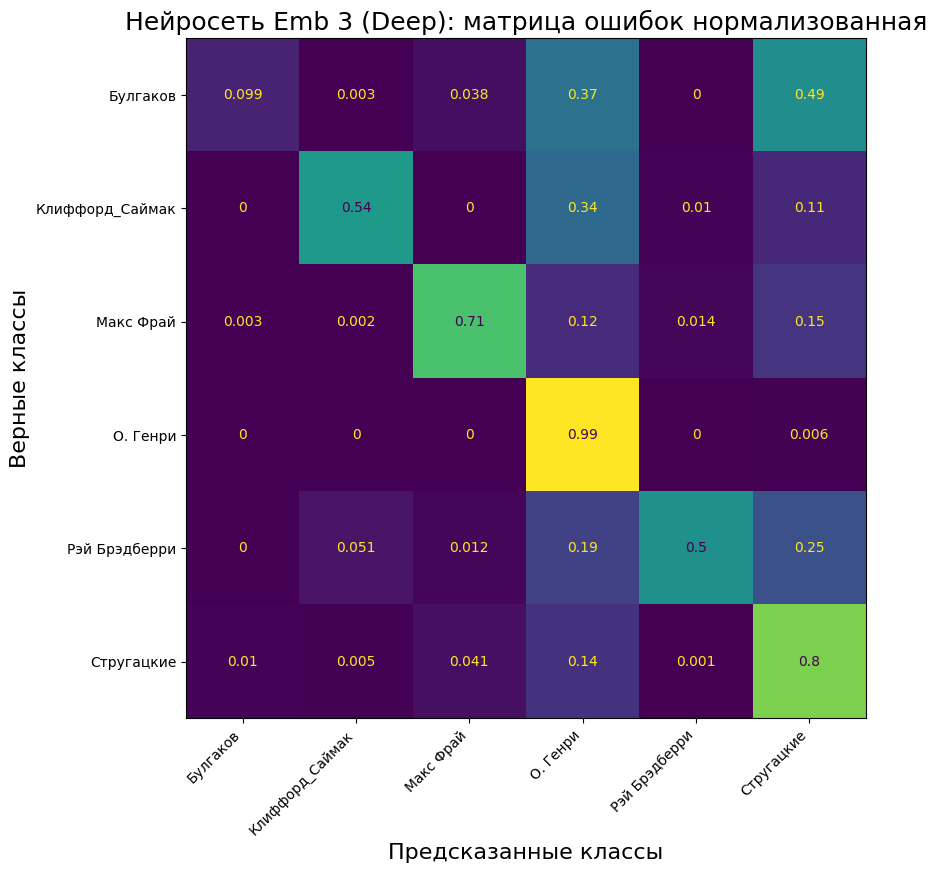

----------------------------------------------------------------------------------------------------
Нейросеть: Emb 3 (Deep)
Класс: Булгаков              49% сеть отнесла к классу Стругацкие           - НЕВЕРНО :-(
Класс: Клиффорд_Саймак       54% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)
Класс: Макс Фрай             71% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: О. Генри              99% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Рэй Брэдберри         50% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Стругацкие            80% сеть отнесла к классу Стругацкие           - ВЕРНО :-)

Средняя точность распознавания:  61%


In [26]:
with timex():
    # Установка параметров
    VOCAB_SIZE = 20000
    WIN_SIZE = 2000
    WIN_HOP = 100

    # Обработка данных
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                        lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
    tokenizer.fit_on_texts(text_train)
    seq_train = tokenizer.texts_to_sequences(text_train)
    seq_test = tokenizer.texts_to_sequences(text_test)

    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

# Автоматическое использование GPU
with tf.device('/GPU:0'):
    model_emb_3 = Sequential()
    model_emb_3.add(Embedding(VOCAB_SIZE, 256, input_length=WIN_SIZE))
    model_emb_3.add(SpatialDropout1D(0.2))
    model_emb_3.add(Flatten())
    model_emb_3.add(Dense(512, activation="relu"))
    model_emb_3.add(Dropout(0.4))
    model_emb_3.add(BatchNormalization())
    model_emb_3.add(Dense(256, activation="relu"))
    model_emb_3.add(Dropout(0.3))
    model_emb_3.add(Dense(CLASS_COUNT, activation='softmax'))
    compile_train_eval_model(model_emb_3,
                             x_train, y_train,
                             x_test, y_test,
                             title='Emb 3 (Deep)')

##Архитектура 7

Время обработки: 4.25 с


d:\anaconda3\envs\Neural_Networks\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 259ms/step - accuracy: 0.5779 - loss: 1.1763 - val_accuracy: 0.5910 - val_loss: 1.2388
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step - accuracy: 0.9996 - loss: 0.0197 - val_accuracy: 0.6613 - val_loss: 0.9478
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 260ms/step - accuracy: 0.9991 - loss: 0.0148 - val_accuracy: 0.6090 - val_loss: 1.0333
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 256ms/step - accuracy: 0.9991 - loss: 0.0048 - val_accuracy: 0.6098 - val_loss: 1.0387
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 260ms/step - accuracy: 0.9999 - loss: 0.0034 - val_accuracy: 0.6041 - val_loss: 1.0249
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 272ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.6177 - val_loss: 1.0188
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 273ms/step - accuracy: 0.9999 - loss: 0.0020 - val_accuracy: 0.6147 - val_loss: 1.0274
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 267ms/step - accuracy: 1.0000 - loss: 5.9250e-04 - val_

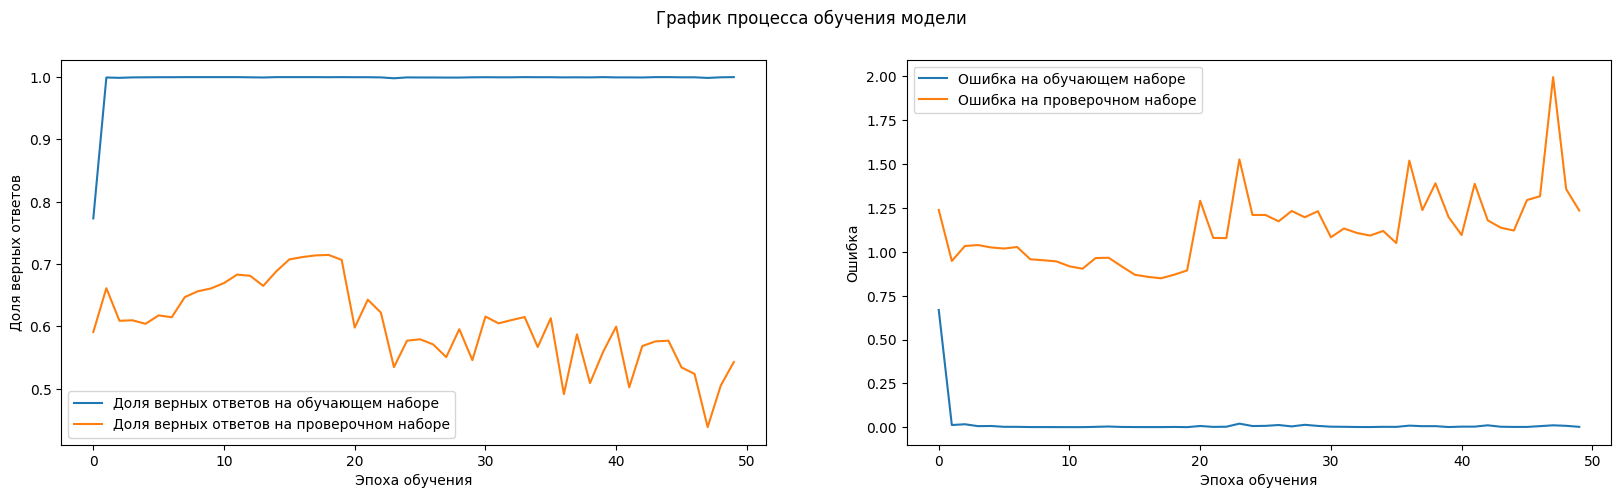

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


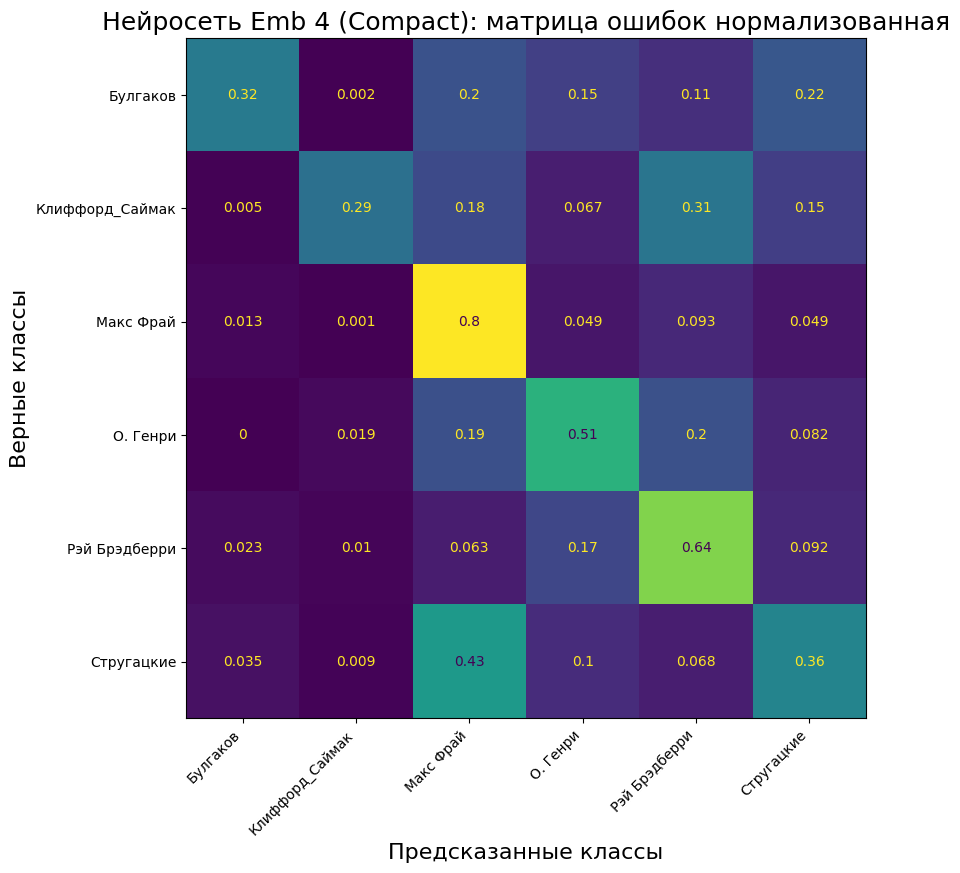

----------------------------------------------------------------------------------------------------
Нейросеть: Emb 4 (Compact)
Класс: Булгаков              32% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Клиффорд_Саймак       31% сеть отнесла к классу Рэй Брэдберри        - НЕВЕРНО :-(
Класс: Макс Фрай             80% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: О. Генри              51% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Рэй Брэдберри         64% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Стругацкие            43% сеть отнесла к классу Макс Фрай            - НЕВЕРНО :-(

Средняя точность распознавания:  49%


In [23]:
with timex():
    # Установка параметров
    VOCAB_SIZE = 18000
    WIN_SIZE = 1700
    WIN_HOP = 250

    # Обработка данных
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                        lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
    tokenizer.fit_on_texts(text_train)
    seq_train = tokenizer.texts_to_sequences(text_train)
    seq_test = tokenizer.texts_to_sequences(text_test)

    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

# Автоматическое использование GPU
with tf.device('/GPU:0'):
    model_emb_4 = Sequential()
    model_emb_4.add(Embedding(VOCAB_SIZE, 128, input_length=WIN_SIZE))
    model_emb_4.add(SpatialDropout1D(0.1))
    model_emb_4.add(Flatten())
    model_emb_4.add(Dense(128, activation="relu"))
    model_emb_4.add(BatchNormalization())
    model_emb_4.add(Dense(CLASS_COUNT, activation='softmax'))
    compile_train_eval_model(model_emb_4,
                             x_train, y_train,
                             x_test, y_test,
                             title='Emb 4 (Compact)')

##Архитектура 8

Время обработки: 4.40 с


d:\anaconda3\envs\Neural_Networks\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 48s 961ms/step - accuracy: 0.4353 - loss: 1.4600 - val_accuracy: 0.6088 - val_loss: 1.2555
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 44s 959ms/step - accuracy: 0.9938 - loss: 0.0562 - val_accuracy: 0.6178 - val_loss: 1.0857
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 44s 950ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.6814 - val_loss: 0.9289
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 44s 955ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.6904 - val_loss: 0.9203
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 45s 973ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.6904 - val_loss: 0.9063
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 44s 966ms/step - accuracy: 1.0000 - loss: 6.8109e-04 - val_accuracy: 0.6994 - val_loss: 0.8935
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 44s 964ms/step - accuracy: 1.0000 - loss: 4.5783e-04 - val_accuracy: 0.7035 - val_loss: 0.8932
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 44s 961ms/step - accuracy: 1.0000 - loss: 3.2244e-0

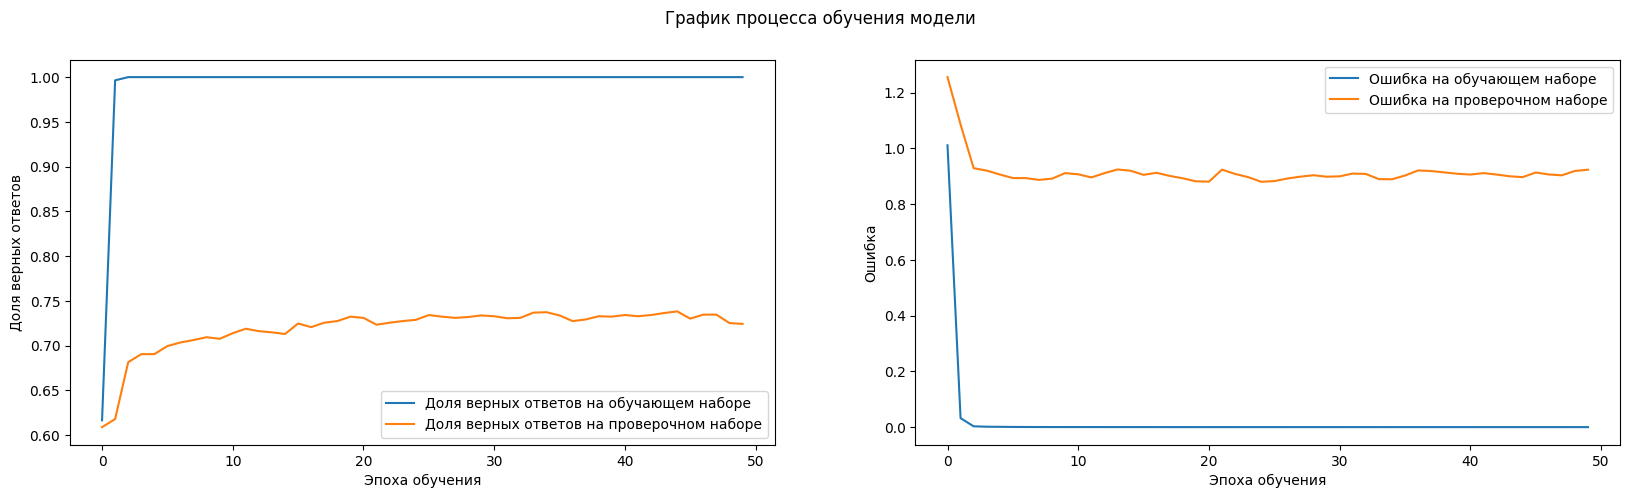

70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step


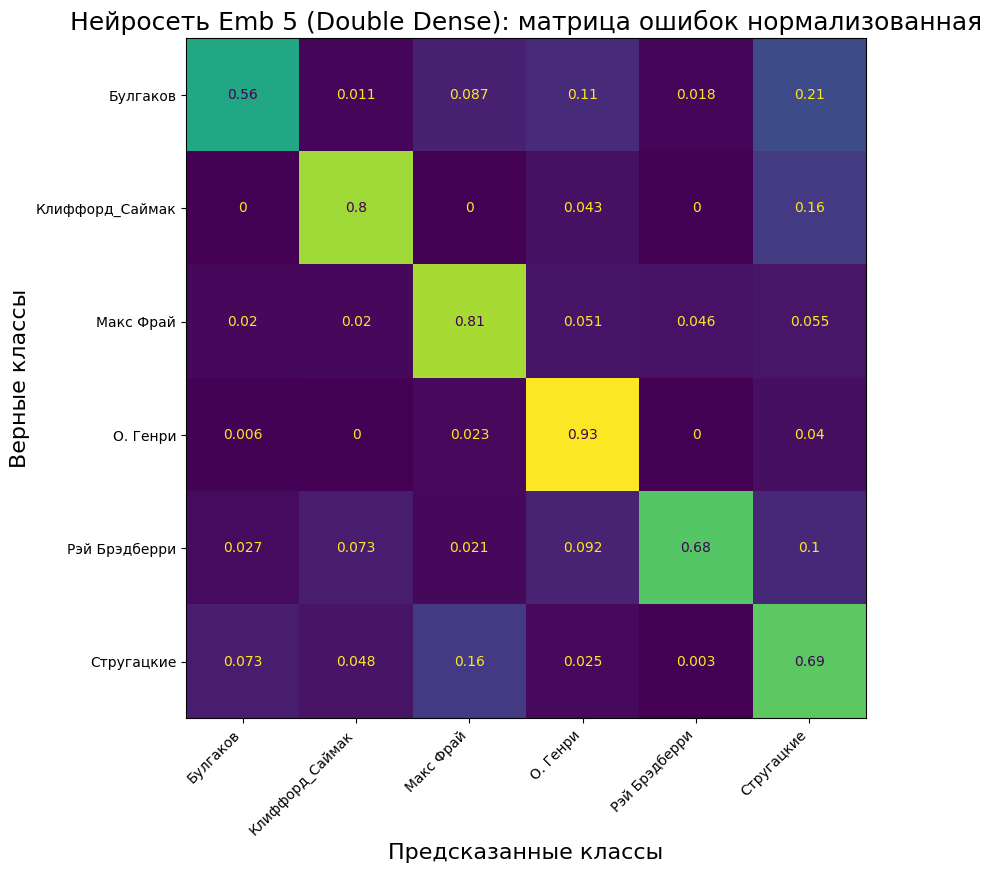

----------------------------------------------------------------------------------------------------
Нейросеть: Emb 5 (Double Dense)
Класс: Булгаков              56% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Клиффорд_Саймак       80% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)
Класс: Макс Фрай             81% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: О. Генри              93% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Рэй Брэдберри         68% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Стругацкие            70% сеть отнесла к классу Стругацкие           - ВЕРНО :-)

Средняя точность распознавания:  75%


In [22]:
with timex():
    # Установка параметров
    VOCAB_SIZE = 14000
    WIN_SIZE = 1600
    WIN_HOP = 300

    # Обработка данных
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                        lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
    tokenizer.fit_on_texts(text_train)
    seq_train = tokenizer.texts_to_sequences(text_train)
    seq_test = tokenizer.texts_to_sequences(text_test)

    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

# Автоматическое использование GPU
with tf.device('/GPU:0'):
    model_emb_5 = Sequential()
    model_emb_5.add(Embedding(VOCAB_SIZE, 200, input_length=WIN_SIZE))
    model_emb_5.add(SpatialDropout1D(0.2))
    model_emb_5.add(Flatten())
    model_emb_5.add(Dense(400, activation="relu"))
    model_emb_5.add(Dropout(0.25))
    model_emb_5.add(BatchNormalization())
    model_emb_5.add(Dense(200, activation="relu"))
    model_emb_5.add(Dropout(0.2))
    model_emb_5.add(Dense(CLASS_COUNT, activation='softmax'))
    compile_train_eval_model(model_emb_5,
                             x_train, y_train,
                             x_test, y_test,
                             title='Emb 5 (Double Dense)')

##Архитектура 9

Время обработки: 3.83 с


d:\anaconda3\envs\Neural_Networks\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.4462 - loss: 2.1111 - val_accuracy: 0.1619 - val_loss: 2.1978
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9946 - loss: 0.1331 - val_accuracy: 0.3306 - val_loss: 1.7306
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 1.0000 - loss: 0.0439 - val_accuracy: 0.2937 - val_loss: 1.7214
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 1.0000 - loss: 0.0279 - val_accuracy: 0.2937 - val_loss: 1.7151
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 1.0000 - loss: 0.0169 - val_accuracy: 0.2937 - val_loss: 1.7073
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 1.0000 - loss: 0.0122 - val_accuracy: 0.2937 - val_loss: 1.6987
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 0.2937 - val_loss: 1.6886
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 1.0000 - loss: 0.0092 - val_accuracy: 0.2937 - val_loss:

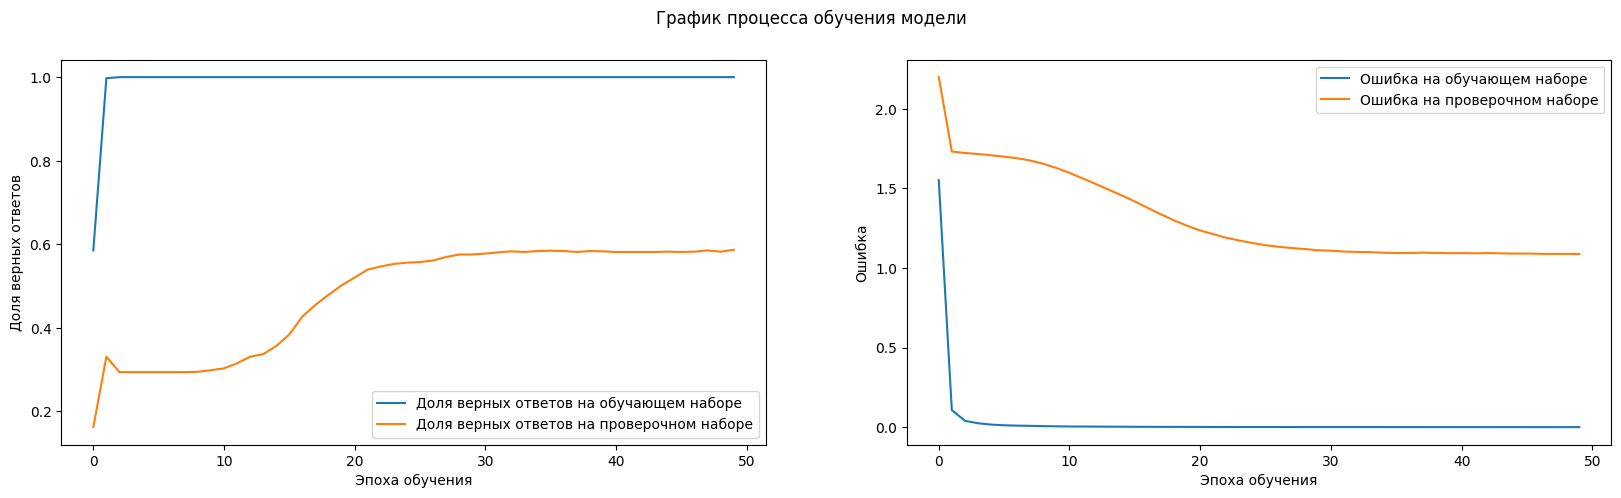

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


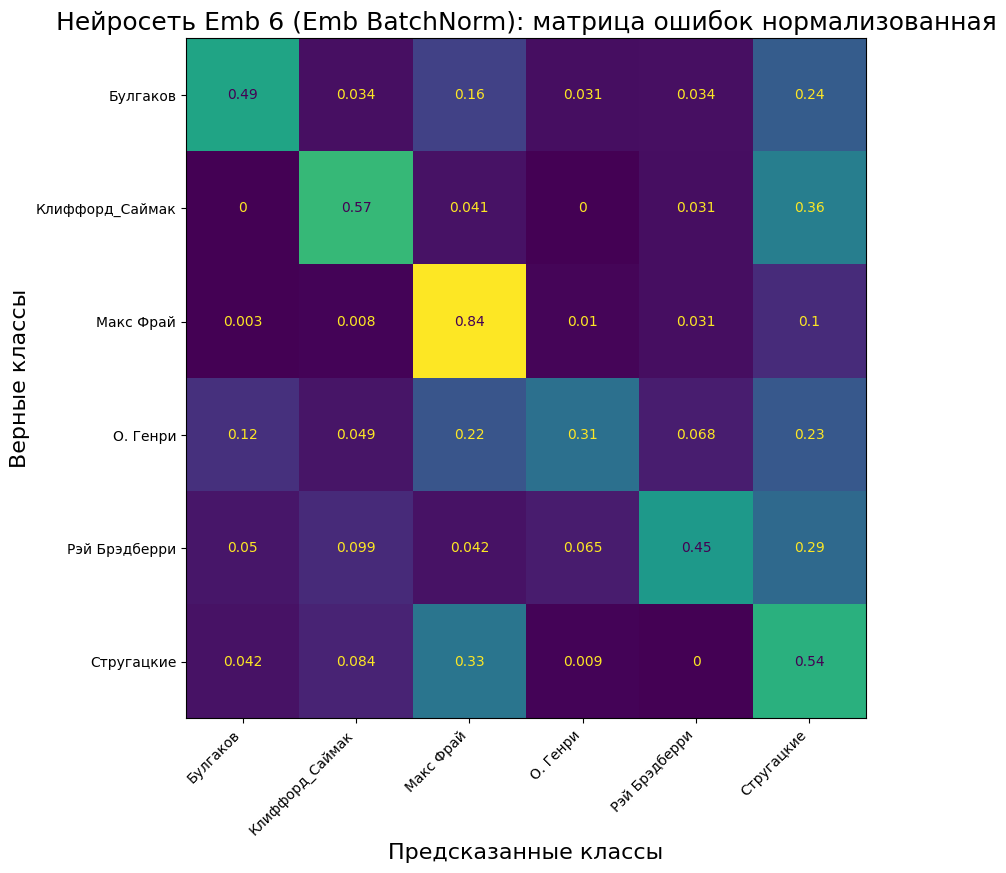

----------------------------------------------------------------------------------------------------
Нейросеть: Emb 6 (Emb BatchNorm)
Класс: Булгаков              49% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Клиффорд_Саймак       57% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)
Класс: Макс Фрай             84% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: О. Генри              31% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Рэй Брэдберри         45% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Стругацкие            54% сеть отнесла к классу Стругацкие           - ВЕРНО :-)

Средняя точность распознавания:  53%


In [21]:
with timex():
    # Установка параметров
    VOCAB_SIZE = 20000
    WIN_SIZE = 2000
    WIN_HOP = 500

    # Обработка данных
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                        lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
    tokenizer.fit_on_texts(text_train)
    seq_train = tokenizer.texts_to_sequences(text_train)
    seq_test = tokenizer.texts_to_sequences(text_test)

    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

# Автоматическое использование GPU
with tf.device('/GPU:0'):
    model_emb_6 = Sequential()
    model_emb_6.add(Embedding(VOCAB_SIZE, 200, input_length=WIN_SIZE))
    model_emb_6.add(BatchNormalization())
    model_emb_6.add(SpatialDropout1D(0.2))
    model_emb_6.add(Flatten())
    model_emb_6.add(Dense(200, activation="relu"))
    model_emb_6.add(Dropout(0.3))
    model_emb_6.add(BatchNormalization())
    model_emb_6.add(Dense(CLASS_COUNT, activation='softmax'))
    compile_train_eval_model(model_emb_6,
                             x_train, y_train,
                             x_test, y_test,
                             title='Emb 6 (Emb BatchNorm)')